In [1]:
import os
os.chdir("/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/")
print(os.getcwd())

/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing


In [2]:
#%%
from pathlib import Path

import numpy as np
import snapatac2 as snap
from gcell._settings import get_setting

annotation_dir = get_setting('annotation_dir')
print("gcell currently using annotation directory:", annotation_dir)


gcell currently using annotation directory: /gpfs/home/asun/.gcell_data/annotations


In [6]:
input_dir = "/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/ssp_agg/outs"

In [7]:
import pandas as pd
from pyranges import PyRanges as pr
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

# cre = pd.read_csv('cCRE_hg38.tsv.gz', sep='\t')
# cre = cre.rename(columns={'#Chromosome': 'Chromosome', 'hg38_Start': 'Start', 'hg38_End': 'End'})[['Chromosome', 'Start', 'End']]
# cre = pr(cre, int64=True).sort()

ad = sc.read_10x_h5(f'{input_dir}/filtered_feature_bc_matrix.h5', gex_only=False)
ad

/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 26105 × 160319
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

This hdf5 contains the count matrix for both gene expression and peak count.
We can have a look at the peaks called by cellranger.

## 1. Cell type assignment

- Load RNA data from processed PBMC10k dataset and borrow the labels. If you have your own cell type labels on the data, skip this step.

- Select top 3000 highly variable genes and perform UMAP to cross check with assigned labels.


Here, I'm going to use the cell type labels from preprocessed snapatac2 object.

In [4]:
rna_filtered = sc.read('rna.h5ad')

/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [8]:
ad = ad[ad.obs.index.isin(rna_filtered.obs.index.values)]

In [9]:
barcode_to_celltype = rna_filtered.obs.to_dict()['predicted.subclass']

ad.obs['predicted.subclass'] = ad.obs.index.map(barcode_to_celltype)


/tmp/ipykernel_15406/2268189917.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['predicted.subclass'] = ad.obs.index.map(barcode_to_celltype)
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
rna_filtered

AnnData object with n_obs × n_vars = 26105 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'predicted.class.score', 'predicted.class', 'predicted.cluster.score', 'predicted.cluster', 'predicted.subclass.score', 'predicted.subclass', 'predicted.cross_species_cluster.score', 'predicted.cross_species_cluster', 'mapping.score', 'unintegrated_clusters', 'seurat_clusters'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank'
    uns: 'neighbors'
    obsm: 'X_integrated_dr', 'X_pca', 'X_ref.umap', 'X_umap.unintegrated'
    varm: 'PCs'
    obsp: 'distances'

In [8]:
ad.obs.head()

,predicted.subclass
AAACAGCCAAACTGCC-1,L5 IT
AAACAGCCAAGCGATG-1,Micro-PVM
AAACAGCCAATTATGC-2,Oligo
AAACAGCCAATTGCGC-1,L5 IT
AAACAGCCAGAAACGT-2,Sst


In [34]:
ad.var

,gene_ids,feature_types,genome,interval
Xkr4,ENSMUSG00000051951,Gene Expression,mm10,chr1:3671497-3671498
Gm1992,ENSMUSG00000089699,Gene Expression,mm10,chr1:3466586-3466587
Gm19938,ENSMUSG00000102331,Gene Expression,mm10,chr1:3658903-3658904
Gm37381,ENSMUSG00000102343,Gene Expression,mm10,chr1:3985983-3986215
Rp1,ENSMUSG00000025900,Gene Expression,mm10,chr1:4360313-4409241
...,...,...,...,...
GL456216.1:31864-32667,GL456216.1:31864-32667,Peaks,mm10,GL456216.1:31864-32667
GL456216.1:34678-35524,GL456216.1:34678-35524,Peaks,mm10,GL456216.1:34678-35524
GL456216.1:48793-49687,GL456216.1:48793-49687,Peaks,mm10,GL456216.1:48793-49687
JH584292.1:12601-13508,JH584292.1:12601-13508,Peaks,mm10,JH584292.1:12601-13508


In [10]:
ad_rna = ad[:, np.where(ad.var.feature_types == 'Gene Expression')[0]]
ad_rna

View of AnnData object with n_obs × n_vars = 26105 × 32285
    obs: 'predicted.subclass'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

Let's calculate the umap on the ad_rna and compare the clustering with assigned cell type labels. In your own analysis, if you already have the labels, you can skip this.

/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/umap/umap_.py:1952: UserWa

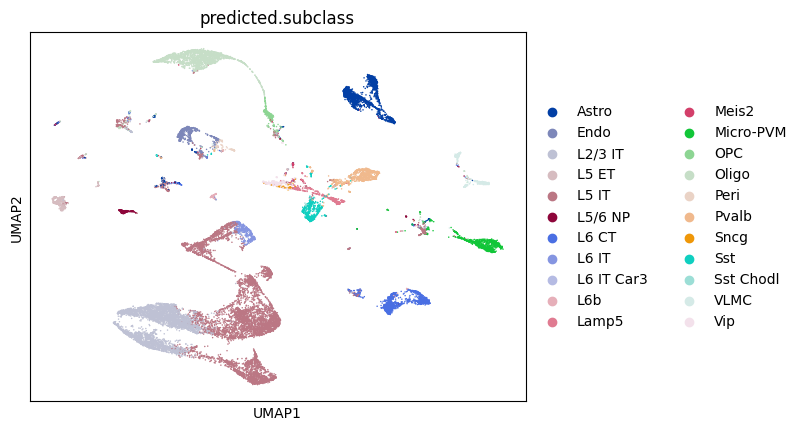

In [11]:
sc.pp.highly_variable_genes(ad_rna, flavor='seurat_v3', n_top_genes=3000)
ad_rna_filtered = ad_rna[:, ad_rna.var.highly_variable]
sc.pp.normalize_total(ad_rna_filtered, target_sum=1e4)
sc.pp.log1p(ad_rna_filtered)
snap.tl.spectral(ad_rna_filtered, features=None)
snap.tl.umap(ad_rna_filtered)
sc.pl.umap(ad_rna_filtered, color='predicted.subclass')


It seems the cell types match well with the data. So now let's collect the ATAC object and look at library sizes of different cell types. Note that if you have a very densely sampled dataset, you can also perform metacell analysis and sample pseudobulk with a consistent library size.

In [12]:
ad_atac = ad[:, np.where(ad.var.feature_types == 'Peaks')[0]]
ad_atac

View of AnnData object with n_obs × n_vars = 26105 × 128034
    obs: 'predicted.subclass'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

We filter for cell types with >100 cells and at least 3M library size.

The selected cell types will be used for training GET models.

In [13]:
print(cell_number)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_15406/449942547.py", line 1, in <module>
    print(cell_number)
          ^^^^^^^^^^^
NameError: name 'cell_number' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 2168, in showtraceback
    Subclasses may override this method to put the traceback on a different
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/IPython/core/ultratb.py", line 1457, in structured_traceback
  File "/gpfs/home/asun/miniforge3/envs/get/lib/python3.12/site-packages/IPython/core/ultratb.py", line 1348, in structured_traceback
  File "/gpfs/home/

In [14]:
# %%

cell_number = ad_atac.obs.groupby('predicted.subclass', observed=False).size().to_dict()
print("The following cell types have more than 100 cells and library size > 3M, adding them to celltype_for_modeling")
celltype_for_modeling = []
for cell_type in cell_number:
    if cell_number[cell_type] > 100:
        celltype_for_modeling.append(cell_type)
        libsize = int(ad_atac[ad_atac.obs["predicted.subclass"] == cell_type].X.sum())
        if libsize > 3000000:
            print(f"{cell_type} number of cells: {cell_number[cell_type]}, library size: {libsize}")

The following cell types have more than 100 cells and library size > 3M, adding them to celltype_for_modeling
Astro number of cells: 2316, library size: 30515516
Endo number of cells: 698, library size: 5141633
L2/3 IT number of cells: 4544, library size: 92593264
L5 ET number of cells: 567, library size: 17506656
L5 IT number of cells: 7664, library size: 147254336
L5/6 NP number of cells: 299, library size: 5034932
L6 CT number of cells: 1745, library size: 35660816
L6 IT number of cells: 578, library size: 12727980
L6b number of cells: 147, library size: 3054597
Lamp5 number of cells: 471, library size: 7468353
Micro-PVM number of cells: 1154, library size: 9088682
OPC number of cells: 575, library size: 6691099
Oligo number of cells: 2246, library size: 19190540
Pvalb number of cells: 1076, library size: 23896946
Sst number of cells: 658, library size: 13008524
VLMC number of cells: 563, library size: 3888340
Vip number of cells: 413, library size: 6744065


In [ ]:
Astro number of cells: 2316, library size: 30515516
Endo number of cells: 698, library size: 5141633
L2/3 IT number of cells: 4544, library size: 92593264
L5 ET number of cells: 567, library size: 17506656
L5 IT number of cells: 7664, library size: 147254336
L5/6 NP number of cells: 299, library size: 5034932
L6 CT number of cells: 1745, library size: 35660816
L6 IT number of cells: 1049, library size: 12727980
L6b number of cells: 147, library size: 3054597
Lamp5 number of cells: 471, library size: 7468353
Micro-PVM number of cells: 1154, library size: 9088682
OPC number of cells: 575, library size: 6691099
Oligo number of cells: 2246, library size: 19190540
Pvalb number of cells: 1076, library size: 23896946
Sst number of cells: 658, library size: 13008524
VLMC number of cells: 563, library size: 3888340
Vip number of cells: 413, library size: 6744065

## 2. Export training data
For each abundant cell type, we'll generate:
1. Peak accessibility file (.atac.bed) containing:
   - Peak coordinates (chr, start, end)
   - Normalized accessibility scores (aCPM, $10^5$ scale factor)
2. Gene expression file (.rna.csv) containing:
   - Gene names
   - Normalized expression values (TPM, $10^6$ scale factor)


In [15]:
# This should be the same as the peaks variable defined above.
import pandas as pd
from pyranges import PyRanges as pr
def get_peak_from_snapatac(atac: snap.AnnData):
    """
    Get the peak names from the snapatac object.

    Args:
        atac: snapatac2 processed AnnData object

    Returns:
        peak_names: pandas DatasFrame with the peak names
    """
    peak_names = pd.DataFrame(atac.var.index.str.split('[:-]').tolist(), columns=['Chromosome', 'Start', 'End'])
    peak_names['Start'] = peak_names['Start'].astype(int)
    peak_names['End'] = peak_names['End'].astype(int)
    return peak_names

peaks = get_peak_from_snapatac(ad_atac)
peaks.shape

(128034, 3)

In [16]:
# %%
def get_peak_acpm_for_cell_type(atac: snap.AnnData, cell_type: str):
    """
    Get the peak acpm for a given cell type.
    """
    peaks = get_peak_from_snapatac(atac)
    counts = np.array(atac[atac.obs["predicted.subclass"] == cell_type].X.sum(0)).flatten()
    acpm = np.log10(counts / counts.sum() * 1e5 + 1)
    peaks['aCPM'] = acpm/acpm.max()
    peaks = peaks.query('Chromosome.str.startswith("chr") & ~Chromosome.str.endswith("M") & ~Chromosome.str.endswith("Y") & ~Chromosome.str.startswith("chrUn")')
    peaks = pr(peaks, int64=True).sort().df
    return peaks

Let's run the function above to save the peak with aCPM for all cell types. Note that here we use the common peak set for all cell types. Later in the dataset we will be able to filter out peaks with no accessibility for each cell type.

In [17]:
# %%
for cell_type in celltype_for_modeling:
    peaks = get_peak_acpm_for_cell_type(ad_atac, cell_type)
    peaks.to_csv(f'{cell_type.replace(" ", "_").replace("/", "-").lower()}.atac.bed', sep='\t', index=False, header=False)

<Axes: xlabel='aCPM', ylabel='length'>

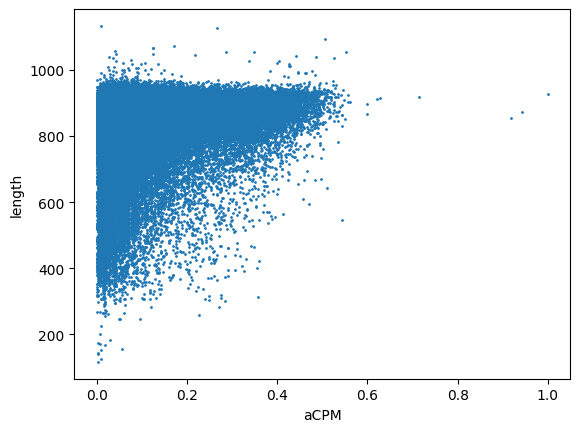

In [18]:
peaks['length'] = peaks['End'] - peaks['Start']
peaks.plot(y='length', x='aCPM', kind='scatter', s=1)

In [19]:
peaks

,Chromosome,Start,End,aCPM,length
0,chr1,3094753,3095675,0.126081,922
1,chr1,3120133,3120689,0.058109,556
2,chr1,3121252,3122011,0.045634,759
3,chr1,3292425,3293285,0.091692,860
4,chr1,3297205,3298011,0.021169,806
...,...,...,...,...,...
127970,chrX,170004064,170004736,0.087507,672
127971,chrX,170004873,170005776,0.103778,903
127972,chrX,170672396,170673174,0.048188,778
127973,chrX,170674517,170675289,0.189751,772


Now let's save the RNA csv files.

In [20]:
# %%
def get_rna_for_cell_type(rna: snap.AnnData, cell_type: str):
    """
    Get the rna for a given cell type.
    """
    counts = rna[rna.obs["predicted.subclass"] == cell_type].X.sum(0)
    counts = np.log10(counts / counts.sum() * 1e6 + 1)
    counts = np.array(counts).flatten()
    rna_tpm = pd.DataFrame(counts, columns=['TPM'])
    rna_tpm['gene_name'] = rna.var.index
    return rna_tpm[['gene_name', 'TPM']].sort_values(by='gene_name', ascending=True)

In [21]:
#%%
for cell_type in celltype_for_modeling:
    rna_tpm = get_rna_for_cell_type(ad_rna, cell_type)
    rna_tpm.to_csv(f'{cell_type.replace(" ", "_").replace("/", "-").lower()}.rna.csv', index=False)

## 3. Query motifs and save data as zarr files.

In [22]:
# NOTE: tabix has to be >= 1.17
! tabix --version

tabix (htslib) 1.21
Copyright (C) 2024 Genome Research Ltd.


In [23]:
import os
from pathlib import Path

from gcell._settings import get_setting
from preprocess_utils import (
    add_atpm,
    add_exp,
    create_peak_motif,
    download_motif,
    get_motif,
    query_motif,
)

annotation_dir = Path(get_setting('annotation_dir'))
print("gcell currently using annotation directory:", annotation_dir)

gcell currently using annotation directory: /gpfs/home/asun/.gcell_data/annotations


### Download motif bed file

This will download the non-redundant motif scanning results to `annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz"`.

In [24]:
motif_bed_url = "https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.archetype_motifs.v1.0.bed.gz"
motif_bed_index_url = "https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.archetype_motifs.v1.0.bed.gz.tbi"


if (
    motif_bed_url
    and motif_bed_index_url
    and not (
        (annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz").exists()
        or (annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz.tbi").exists()
    )
):
    download_motif(motif_bed_url, motif_bed_index_url, motif_dir=annotation_dir)
    motif_bed = str(annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz")
else:
    motif_bed = str(annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz")

### Query motif

In [25]:
peak_bed = "l2-3_it.atac.bed" # since all cell types share the same peak set, when querying motifs, we can just use one cell type to query motifs.
peaks_motif = query_motif(peak_bed, motif_bed)
get_motif_output = get_motif(peak_bed, peaks_motif)


Peak motif extraction completed. Results saved in get_motif.bed


## 4. Create peak motif zarr file
Create a peak x motif matrix stored in a zarr file. If you are working on multiple cell types with the same peak set, you can use the same peak bed and zarr file for all cell types.

In [26]:
import zarr
import pandas as pd
import numpy as np
def create_peak_motif(peak_motif_bed, output_zarr, peak_bed):
    """
    Create a peak motif zarr file from a peak motif bed file.

    This function reads a peak motif bed file, pivots the data, and saves it to a zarr file.
    The zarr file contains three datasets: 'data', 'peak_names', 'motif_names', and 'accessibility'.
    The 'data' dataset is a sparse matrix containing the peak motif data.
    The 'peak_names' dataset contains the peak names.
    The 'motif_names' dataset contains the motif names.

    Args:
        peak_motif_bed (str): Path to the peak motif bed file.
        output_zarr (str): Path to the output zarr file.
    """
    import pandas as pd
    motif_annotations = pd.read_excel('https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/motif_annotations.xlsx')
    motif_cluster_ids = motif_annotations.Name.unique()
    # Read the peak motif bed file
    peak_motif = pd.read_csv(
        peak_motif_bed,
        sep="\t",
        header=None,
        names=["Chromosome", "Start", "End", "Motif_cluster", "Score"],
    )

    # Pivot the data
    peak_motif_pivoted = peak_motif.pivot_table(
        index=["Chromosome", "Start", "End"],
        columns="Motif_cluster",
        values="Score",
        fill_value=0,
    )

    peak_motif_pivoted.reset_index(inplace=True)
    # add missing motif columns
    for motif_cluster_id in motif_cluster_ids:
        if motif_cluster_id not in peak_motif_pivoted.columns:
            peak_motif_pivoted[motif_cluster_id] = 1
    # Create the 'Name' column
    peak_motif_pivoted["Name"] = peak_motif_pivoted.apply(
        lambda x: f'{x["Chromosome"]}:{x["Start"]}-{x["End"]}', axis=1
    )
    peak_motif_pivoted = peak_motif_pivoted.drop(columns=["Chromosome", "Start", "End"])

    # Read the original peak bed file
    original_peaks = pd.read_csv(
        peak_bed, sep="\t", header=None, names=["Chromosome", "Start", "End", "Score"]
    )

    # exclude chrM and chrY
    original_peaks = original_peaks[~original_peaks.Chromosome.isin(["chrM", "chrY"])]
    original_peaks["Name"] = original_peaks.apply(
        lambda x: f'{x["Chromosome"]}:{x["Start"]}-{x["End"]}', axis=1
    )
    
    new_columns = list(motif_cluster_ids) + ["Name"]

    # sort motif columns
    peak_motif_pivoted = peak_motif_pivoted[new_columns]

    # Merge the pivoted data with the original peaks
    merged_data = pd.merge(original_peaks, peak_motif_pivoted, on="Name", how="left")

    # Fill NaN values with 0 for motif columns
    motif_columns = [
        col
        for col in merged_data.columns
        if col not in ["Chromosome", "Start", "End", "Score", "Name"]
    ]
    
    merged_data[motif_columns] = merged_data[motif_columns].fillna(0)
    peak_length = (merged_data.End - merged_data.Start).values / 400 # convert to kb
    merged_data[motif_columns] = merged_data[motif_columns].div(peak_length, axis=0)
    # Prepare data for zarr storage
    name_values = list(merged_data["Name"].values)
    motif_values = motif_columns

    # Create sparse matrix
    motif_data_matrix = merged_data[motif_columns].values
    # Open zarr store and save data
    from numcodecs import Blosc

    z = zarr.open(output_zarr, mode="w")
    z.create_dataset(
        "data",
        data=motif_data_matrix.data,
        chunks=(1000, motif_data_matrix.shape[1]),
        dtype=np.float32,
        compressor=Blosc(cname="zstd", clevel=3, shuffle=Blosc.BITSHUFFLE),
        shape=motif_data_matrix.shape,
    )
    z.create_dataset("peak_names", data=name_values)
    z.create_dataset("motif_names", data=motif_values)

    print(f"Peak motif data saved to {output_zarr}")

create_peak_motif(get_motif_output, "aggr_multiome.zarr", peak_bed) # all cell types will later be added to the same zarr file as we use the same peak set.

Peak motif data saved to aggr_multiome.zarr


In [27]:
#create_peak_motif(get_motif_output, "aggr_multiome.zarr", peak_bed) # all cell types will later be added to the same zarr file as we use the same peak set.


### Add aCPM data to region x motif matrix
For each cell type, we will save it's aCPM values to the `pbmc10k_multiome.zarr/atpm/{celltype}/` folder

In [28]:
celltype_for_modeling

['Astro',
 'Endo',
 'L2/3 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6b',
 'Lamp5',
 'Meis2',
 'Micro-PVM',
 'OPC',
 'Oligo',
 'Peri',
 'Pvalb',
 'Sst',
 'VLMC',
 'Vip']

In [29]:
for cell_type in celltype_for_modeling:
    add_atpm(
        "aggr_multiome.zarr",
        f"{cell_type.replace(" ", "_").replace("/", "-").lower()}.atac.bed",
        cell_type,
    )

       Chromosome      Start        End      aTPM                      Name
0            chr1    3094753    3095675  0.025909      chr1:3094753-3095675
1            chr1    3120133    3120689  0.014934      chr1:3120133-3120689
2            chr1    3121252    3122011  0.014307      chr1:3121252-3122011
3            chr1    3292425    3293285  0.011142      chr1:3292425-3293285
4            chr1    3297205    3298011  0.008574      chr1:3297205-3298011
...           ...        ...        ...       ...                       ...
127970       chrX  170004064  170004736  0.042991  chrX:170004064-170004736
127971       chrX  170004873  170005776  0.088835  chrX:170004873-170005776
127972       chrX  170672396  170673174  0.012414  chrX:170672396-170673174
127973       chrX  170674517  170675289  0.116979  chrX:170674517-170675289
127974       chrX  170677032  170677956  0.025315  chrX:170677032-170677956

[127975 rows x 5 columns]
       Chromosome      Start        End      aTPM            

### Add expression and TSS data to region x motif matrix

In [30]:
for cell_type in celltype_for_modeling:
    add_exp(
        "aggr_multiome.zarr",
        f"{cell_type.replace(" ", "_").replace("/", "-").lower()}.rna.csv",
        f"{cell_type.replace(" ", "_").replace("/", "-").lower()}.atac.bed",
        cell_type,
        assembly="mm10",
        version="M36",
        extend_bp=300, # extend TSS region to 300bp upstream and downstream when overlapping with peaks
        id_or_name="gene_name", # use gene_name or gene_id to match the gene expression data, checkout your rna.csv file column names, should be either [gene_name, TPM] or [gene_id, TPM]
)

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/preprocess_utils.py:338: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["index", "Strand"])
join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
/gpfs/home/asun/jin_lab/get/pipeline2_aggr_preprocessing/preprocess_utils.py:338: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=Tru

### Clean up intermediate files

In [31]:
for file in [peaks_motif, get_motif_output]:
    os.remove(file)

This has conclude the data processing steps.